In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytesseract

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
train_pd = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/emnist/emnist-letters-train.csv')
test_pd = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/emnist/emnist-letters-test.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print('training dataset dimensions: ', train_pd.shape)
print('test dataset dimensions: ', test_pd.shape, '\n')

training dataset dimensions:  (88799, 785)
test dataset dimensions:  (14799, 785) 



In [ ]:
def flip_img(data, row_num):
    #print(data)
    return np.transpose(data.values[row_num,1:].reshape(28, 28), axes=[1,0]).reshape(28,28,1)

In [ ]:
columns = ['labels']
for i in range(train_pd.shape[1]-1):
    columns.append(i)

train_pd.columns = columns
test_pd.columns = columns

classes = train_pd['labels'].unique()
print('number of classes: ', len(classes))

train_pd.head()

number of classes:  26


,labels,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
data = []
for i in range(88799):
  data.append(flip_img(train_pd,i))
np_data = np.array(data)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(np_data,
                                                  train_pd.labels - 1,
                                                  test_size=0.03,
                                                  random_state=42)

x_train = x_train / 255.0
x_val = x_val / 255.0

testX = test_pd.values[:, 1:].reshape(test_pd.shape[0],28, 28, 1).astype('float32')
x_test = testX / 255.0
y_test = test_pd['labels'].values - 1 # this is just to make the neurons in the output layer start at 0

print('trianing set: ', x_train.shape, y_train.shape)
print('validation set: ', x_val.shape, y_val.shape)
print('test set: ', x_test.shape, y_test.shape)

trianing set:  (86135, 28, 28, 1) (86135,)
validation set:  (2664, 28, 28, 1) (2664,)
test set:  (14799, 28, 28, 1) (14799,)


In [ ]:
train = tf.data.Dataset.from_tensor_slices((x_train, y_train))

In [ ]:
train

<TensorSliceDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
val = tf.data.Dataset.from_tensor_slices((x_val,y_val))
test = tf.data.Dataset.from_tensor_slices((x_test,y_test))

In [ ]:
pre_model = tf.keras.Sequential([
    tf.keras.layers.RandomZoom(height_factor=(-0.1,0.1), width_factor=(-0.1,0.1)),
    tf.keras.layers.RandomRotation(0.075, fill_mode='nearest'),
    tf.keras.layers.RandomBrightness(0.1, value_range=(0.,1.)),
    tf.keras.layers.RandomTranslation(height_factor=(-0.1,0.1), width_factor=(-0.1,0.1))
])

In [ ]:
train_aug = train.map(
  lambda x, y: (pre_model(x), y))

In [ ]:
val_aug = val.map(
  lambda x, y: (pre_model(x), y))

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


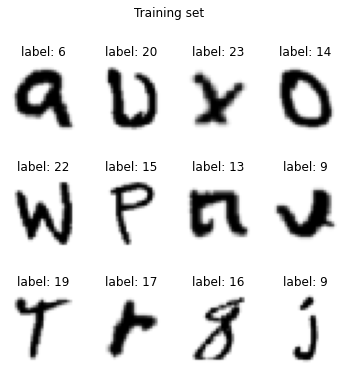

In [ ]:
plt.figure(figsize=(6, 6))
plt.suptitle('Training set')
k=1
for i,j in val_aug.take(12):
    print(type(i))
    plt.subplot(3, 4, k)
    plt.imshow(i.numpy().reshape(28,28), cmap='binary')
    plt.title(f'label: {j}')
    plt.axis('off')
    k+=1

In [ ]:
y_aug_train = np.stack([y for x, y in train_aug], axis=0)
x_aug_train = np.stack([x for x, y in train_aug], axis=0)

In [ ]:
x_train_combined = np.concatenate((x_train, x_aug_train))
y_train_combined = np.concatenate((y_train, y_aug_train))

8


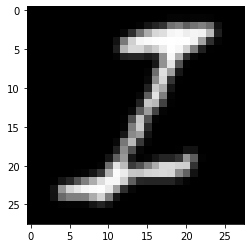

In [ ]:
plt.imshow(x_train_combined[0].reshape((28,28)), cmap='gray')
print(y_train_combined[0])

In [ ]:
y_aug_train.shape

(86135,)

In [ ]:
y_aug_val = np.stack([y for x, y in val_aug], axis=0)
x_aug_val = np.stack([x for x, y in val_aug], axis=0)

In [ ]:
x_val_combined = np.concatenate((x_val, x_aug_val))
y_val_combined = np.concatenate((y_val, y_aug_val))

In [ ]:
x_aug_train[0].shape

(28, 28, 1)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Reshape(input_shape=(784,), target_shape=(28,28,1)),
    tf.keras.layers.Conv2D(64,3, padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(32,3, padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(128,3, padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Normalization(),
    tf.keras.layers.Dense(1024,activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Normalization(),
    tf.keras.layers.Dense(256,activation='elu'),
    tf.keras.layers.Dense(512,activation='swish'),
    tf.keras.layers.Normalization(),
    tf.keras.layers.Dense(len(classes),activation='softmax')])
# compile model
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#model.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
MCP = ModelCheckpoint('Best_points.h5',verbose=1,save_best_only=True,monitor='val_accuracy',mode='max')
ES = EarlyStopping(monitor='val_accuracy',min_delta=0,verbose=0,restore_best_weights = True,patience=7,mode='max')
RLP = ReduceLROnPlateau(monitor='val_loss',patience=5,factor=0.2,min_lr=0.01)

In [ ]:
history = model.fit(x_train_combined, y_train_combined, epochs=30,validation_data=(x_val_combined, y_val_combined),callbacks=[MCP, ES])

Epoch 1/30
5384/5384 [==============================] - ETA: 0s - loss: 0.5160 - accuracy: 0.8335
Epoch 1: val_accuracy improved from -inf to 0.89377, saving model to Best_points.h5
5384/5384 [==============================] - 42s 6ms/step - loss: 0.5160 - accuracy: 0.8335 - val_loss: 0.3364 - val_accuracy: 0.8938
Epoch 2/30
5381/5384 [============================>.] - ETA: 0s - loss: 0.3339 - accuracy: 0.8933
Epoch 2: val_accuracy improved from 0.89377 to 0.90165, saving model to Best_points.h5
5384/5384 [==============================] - 31s 6ms/step - loss: 0.3339 - accuracy: 0.8933 - val_loss: 0.3280 - val_accuracy: 0.9017
Epoch 3/30
5377/5384 [============================>.] - ETA: 0s - loss: 0.3057 - accuracy: 0.9027
Epoch 3: val_accuracy improved from 0.90165 to 0.92417, saving model to Best_points.h5
5384/5384 [==============================] - 30s 6ms/step - loss: 0.3057 - accuracy: 0.9027 - val_loss: 0.2377 - val_accuracy: 0.9242
Epoch 4/30
5382/5384 [========================

In [ ]:
data = []
for i in range(14799):
  data.append(flip_img(test_pd,i))
np_data = np.array(data)
test_x = np_data/255.0

In [ ]:
evaluate = model.evaluate(test_x, y_test)

463/463 [==============================] - 2s 4ms/step - loss: 0.2549 - accuracy: 0.9290


In [ ]:
model.save('ocr.h5')

In [ ]:
import cv2

In [ ]:
def sort_contours(cnts, method="left-to-right"):
	# initialize the reverse flag and sort index
	reverse = False
	i = 0
	# handle if we need to sort in reverse
	if method == "right-to-left" or method == "bottom-to-top":
		reverse = True
	# handle if we are sorting against the y-coordinate rather than
	# the x-coordinate of the bounding box
	if method == "top-to-bottom" or method == "bottom-to-top":
		i = 1
	# construct the list of bounding boxes and sort them from top to
	# bottom
	boundingBoxes = [cv2.boundingRect(c) for c in cnts]
	(cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
		key=lambda b:b[1][i], reverse=reverse))
	# return the list of sorted contours and bounding boxes
	return (cnts, boundingBoxes)

In [ ]:
def ocr_pipeline(pred_img):
  grayImage = cv2.cvtColor(pred_img, cv2.COLOR_BGR2GRAY)
  im2 = pred_img.copy()
  blured1 = cv2.medianBlur(grayImage,3)
  blured2 = cv2.medianBlur(grayImage,51)
  divided = np.ma.divide(blured1, blured2).data
  normed = np.uint8(255*divided/divided.max())
  th, threshed = cv2.threshold(normed, 150, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
  #threshed = ~threshed
  #plt.imshow(threshed, cmap='binary')
  #blackAndWhiteImage = cv2.adaptiveThreshold(grayImage,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,41,15)
  #plt.imshow(blackAndWhiteImage, cmap='binary')
  rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,1))
  dilation = cv2.dilate(threshed, rect_kernel, iterations = 2)
  #plt.imshow(dilation, cmap='binary')
  contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  contours = sort_contours(contours, method='left-to-right')[0]
  cropped = []
  pred = []
  #print(len(contours))
  for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    rect = cv2.rectangle(im2, (x, y), (x + w, y + h), (0, 255, 0), 2)
    #cropped.append(threshed[y:y + h, x:x + w])
    cropped.append(cv2.copyMakeBorder(threshed[y:y + h, x:x + w], 5, 5, 5, 5, cv2.BORDER_CONSTANT, None, value = 0))
    #plt.imshow(cv2.copyMakeBorder(threshed[y:y + h, x:x + w], 10, 10, 10, 10, cv2.BORDER_CONSTANT, None, value = 0), cmap='binary')
  #plt.imshow(im2, cmap='gray')
  #print(cropped)
  r = []
  for c in cropped:
    if(c.any()):
      #dilation1 = cv2.dilate(c, rect_kernel, iterations = 1)
      res = cv2.resize(c,(28,28),interpolation=cv2.INTER_AREA)
      r.append(res)
      #plt.imshow(res, cmap='gray')
      my_pred = model.predict(pd.DataFrame(res.flatten()).T)
      pred.append(np.argmax(my_pred)+1)
  plt.imshow(r[1], cmap='binary')
  return pred

In [ ]:
def list_to_string(l):
  s = ''
  dictionary = 'abcdefghijklmnopqrstuvwxyz'
  for i in l:
    s+= dictionary[i-1]
  return s

In [ ]:
import nltk

# importing jaccard distance
# and ngrams from nltk.util
from nltk.metrics.distance import jaccard_distance
from nltk.util import ngrams

In [ ]:
nltk.download('words')
from nltk.corpus import words


correct_words = words.words()

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [ ]:
import nltk
from nltk.corpus import words
from nltk.metrics.distance import (
    edit_distance,
    jaccard_distance,
    )
from nltk.util import ngrams
nltk.download('words')
import pandas

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [ ]:
correct_spellings = words.words()
spellings_series = pandas.Series(correct_spellings)
spellings_series

0                 A
1                 a
2                aa
3               aal
4             aalii
            ...    
236731       yellow
236732          yes
236733    yesterday
236734          you
236735        young
Length: 236736, dtype: object

In [ ]:
def jaccard(entries, gram_number):

    outcomes = []
    for entry in entries: #iteratively for loop
        spellings = spellings_series[spellings_series.str.startswith(entry[0])]
        distances = ((jaccard_distance(set(ngrams(entry, gram_number)),
                                       set(ngrams(word, gram_number))), word)
                     for word in spellings)
        closest = min(distances)
        outcomes.append(closest[1])
    return outcomes

In [ ]:
temp = [(jaccard_distance(set(ngrams(string_predicted, 2)),
                              set(ngrams(w, 2))),w)
            for w in correct_words if w[0]==string_predicted[0]]
#print(temp)
print(sorted(temp, key = lambda val:val[0])[0][1])

natural


In [ ]:
ocr_model = tf.keras.models.load_model('Best_points (1).h5')

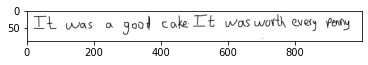

In [ ]:
img = cv2.imread('test2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

h, w, c = img.shape

if w > 1000:

    new_w = 1000
    ar = w/h
    new_h = int(new_w/ar)

    img = cv2.resize(img, (new_w, new_h), interpolation = cv2.INTER_AREA)
plt.imshow(img)

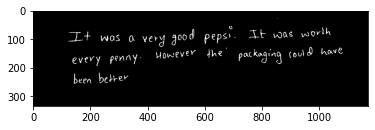

In [ ]:
def thresholding(pred_img):
    grayImage = cv2.cvtColor(pred_img, cv2.COLOR_BGR2GRAY)
    im2 = pred_img.copy()
    blured1 = cv2.medianBlur(grayImage,3)
    blured2 = cv2.medianBlur(grayImage,51)
    divided = np.ma.divide(blured1, blured2).data
    normed = np.uint8(255*divided/divided.max())
    th, thresh = cv2.threshold(normed, 150, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    plt.imshow(thresh, cmap='gray')
    return thresh

thresh_img = thresholding(img)

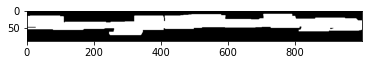

In [ ]:
kernel = np.ones((3,85), np.uint8)
dilated = cv2.dilate(thresh_img, kernel, iterations = 1)
plt.imshow(dilated, cmap='gray')

In [ ]:
(contours, heirarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
sorted_contours_lines = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1])

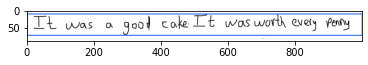

In [ ]:
img2 = img.copy()

for ctr in sorted_contours_lines:

    x,y,w,h = cv2.boundingRect(ctr)
    cv2.rectangle(img2, (x,y), (x+w, y+h), (40, 100, 250), 2)

plt.imshow(img2)

In [ ]:
len(sorted_contours_lines)

1

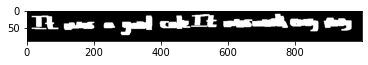

In [ ]:
kernel = np.ones((3,15), np.uint8)
dilated2 = cv2.dilate(thresh_img, kernel, iterations = 1)
plt.imshow(dilated2, cmap='gray')

In [ ]:
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
dilation = cv2.dilate(thresh_img, rect_kernel, iterations = 1)

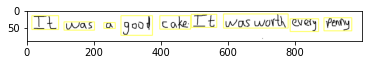

In [ ]:
img3 = img.copy()
words_list = []

for line in sorted_contours_lines:

    # roi of each line
    x, y, w, h = cv2.boundingRect(line)
    roi_line = dilated2[y:y+w, x:x+w]

    # draw contours on each word
    (cnt, heirarchy) = cv2.findContours(roi_line.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sorted_contour_words, bbox = sort_contours(cnt)

    for word in sorted_contour_words:

        if cv2.contourArea(word) < 400:
            continue

        x2, y2, w2, h2 = cv2.boundingRect(word)
        if [x+x2, y+y2, x+x2+w2, y+y2+h2] not in words_list:
          words_list.append([x+x2, y+y2, x+x2+w2, y+y2+h2])
        cv2.rectangle(img3, (x+x2, y+y2), (x+x2+w2, y+y2+h2), (255,255,100),2)

plt.imshow(img3)

In [ ]:
len(words_list)

9

In [ ]:
for i in range(0,len(words_list)):
    #print(type(i))
    ninth_word = words_list[i]
    roi_9 = img[ninth_word[1]:ninth_word[3], ninth_word[0]:ninth_word[2]]
    plt.subplot(1, 19, i+1)
    plt.imshow(roi_9)
    plt.axis('off')

In [ ]:
t2 = cv2.imread('h.jpg')
t2 = cv2.cvtColor(t2, cv2.COLOR_BGR2RGB)

1/1 [==============================] - 0s 17ms/step


'hqwemwfr'

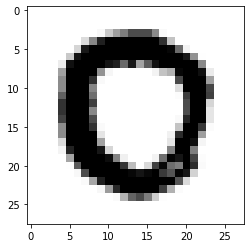

In [ ]:
pred = ocr_pipeline(t2)
string_predicted = list_to_string(pred)
string_predicted

1/1 [==============================] - 0s 18ms/step


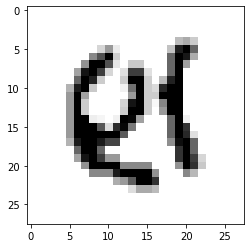

In [ ]:
ninth_word = words_list[7]
roi = img[ninth_word[1]:ninth_word[3], ninth_word[0]:ninth_word[2]]
plt.imshow(roi)
prediction = ocr_pipeline(roi)

In [ ]:
prediction

[21, 14]

In [ ]:
string_predicted = list_to_string(prediction)
string_predicted

'mmy'

In [ ]:
temp2 = [(jaccard_distance(set(ngrams(string_predicted, 2)),
                              set(ngrams(w, 2))),w)
            for w in correct_words if w[0]==string_predicted[0]]
#print(temp)
print(sorted(temp2, key = lambda val:val[0])[0][1])

gaddi


In [ ]:
for i in range(1,5):
  print(jaccard([string_predicted], i))

['gad']
['gaddi']
['g']
['g']


In [ ]:
word_model = tf.keras.models.load_model('model_1.h5')

OSError: ignored

In [ ]:
import cv2

In [ ]:
img = cv2.imread('t2.jpg')
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [ ]:
text = pytesseract.image_to_string(img)

In [ ]:
print(text)

‘The studio was filled with the rich odor
of roses, and when the light summer
wind stirred amidst the trees of the
garden there came through the open
door the heavy scent of the lilac, or the
more delicate perfume of the pink-
flowering thorn.

The studio was filled with the rich
odor of roses, and when the light
summer wind stirred amidst the trees
of the garden there came through the
‘open door the heavy scent of the lilac,
orthe more delicate perfume of the
pinkeflowering thorn.



In [ ]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import pandas as pd
import numpy as np
import heapq
import matplotlib.pyplot as plt

In [ ]:
import nltk
nltk.download("gutenberg")
nltk.download('punkt')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
corpus = nltk.corpus.gutenberg.sents('melville-moby_dick.txt')[:2000]

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
word_index = tokenizer.word_index
total_unique_words = len(tokenizer.word_index) + 1

In [ ]:
max_len=171

In [ ]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
def word_prediction(seed_text, next_words):
  for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_len-1, padding='pre')
  predicted = np.argmax(word_model.predict(token_list, verbose=1), axis=-1)
  ouput_word = ""
  for word, index in tokenizer.word_index.items():
    if index == predicted:
      output_word = word
      break
  seed_text += ' '+output_word
  print(seed_text)

In [ ]:
#"For my part I abominate all honourable respectable toils trials and tribulations of every kind whatsoever."
word_prediction('For my part I abominate all honourable respectable toils trials and tribulations of every kind',5)

NameError: ignored

In [ ]:
import pandas as pd
from bs4 import BeautifulSoup
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
def html_tag_remove(review):
  soup = BeautifulSoup(review, 'lxml')
  return soup.get_text()

In [ ]:
def removeContractions(review):
    phrase = re.sub(r"won't", "will not", review)
    phrase = re.sub(r"can\'t", "can not", review)
    phrase = re.sub(r"n\'t", " not", review)
    phrase = re.sub(r"\'re", " are", review)
    phrase = re.sub(r"\'s", " is", review)
    phrase = re.sub(r"\'d", " would", review)
    phrase = re.sub(r"\'ll", " will", review)
    phrase = re.sub(r"\'t", " not", review)
    phrase = re.sub(r"\'ve", " have", review)
    phrase = re.sub(r"\'m", " am", review)
    return phrase

In [ ]:
def removeAlphaNumericWords(review):
     return re.sub("\S*\d\S*", "", review).strip()
def removeSpecialChars(review):
     return re.sub('[^a-zA-Z]', ' ', review)
def scorePartition(x):
    if x < 3:
        return 0
    return 1

In [ ]:
def TextPreprocessing(review):
    review = html_tag_remove(review)
    review = removeContractions(review)
    review = removeAlphaNumericWords(review)
    review = removeSpecialChars(review)
    review = review.lower()
    review = review.split()
    lmtzr = WordNetLemmatizer()
    review = [lmtzr.lemmatize(word, 'v') for word in review if not word in set(stopwords.words('english'))]
    review = " ".join(review)
    return review

In [ ]:
import joblib
sentiment_model = joblib.load('sentiment_model.joblib')

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Reviews.csv', nrows=80000)
dataset = dataset.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

In [ ]:
import tqdm
corpus1 = []
for index, row in tqdm.tqdm(dataset.iterrows()):
    review = TextPreprocessing(row['Text'])
    corpus1.append(review)

71493it [11:44, 101.42it/s]


In [ ]:
import pickle

with open('corpus1.pkl','rb') as f:
  corpus1 = pickle.load(f)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(1,3), max_features = 5000)
X = cv.fit_transform(corpus1).toarray()

In [ ]:
def predictNewReview(newReview):
  if newReview =='':
    print('Invalid Review')
  else:
    newReview = TextPreprocessing(newReview)
    new_review = cv.transform([newReview]).toarray()
    prediction =  sentiment_model.predict(new_review)
    print(prediction)
    if prediction[0] == 1:
      print( "Positive Review" )
    else:
      print( "Negative Review")

In [ ]:
import pickle
with open('corpus1.pkl', 'wb') as f:
  pickle.dump(corpus1, f)

In [ ]:
predictNewReview('It was a very good cake. The was worth every penny. However the packaging was not good')

[1]
Positive Review
